<a href="https://colab.research.google.com/github/Babacargaye/deep-learning-ensai-2025/blob/master/brain_tumor_methodology_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor MRI Classification — Methodology-First Deep Learning Notebook

We use the Kaggle dataset **Brain Tumor MRI Dataset** and implement:

- A **classical ML baseline** (HOG + Logistic Regression) to justify deep learning.
- A **CNN trained from scratch** (simple but strong baseline for images).
- **Transfer learning** with a pretrained model (EfficientNet) to improve generalization on limited data.
- A solid **evaluation protocol**: train/val/test split, learning curves, confusion matrix, precision/recall/F1, ROC-AUC (binary), and error analysis.

> **Important note (medical context):** In tumor detection, **false negatives** can be more harmful than false positives. Therefore, we go beyond accuracy and track **recall/sensitivity** and the confusion matrix.

---

## How to run

### On Kaggle
If you add the dataset to the notebook, it will typically be available at:
`/kaggle/input/brain-tumor-mri-dataset`

### Locally
Download the dataset and set `DATA_DIR` to the folder containing class subfolders.

---

## Reproducibility

We set random seeds where possible. Exact reproducibility can still vary by hardware/GPU.


## 0. Setup
We import libraries and set up a few helper functions.

- **TensorFlow/Keras** for deep learning models
- **scikit-learn** for baseline model and evaluation metrics
- **OpenCV / skimage** for feature extraction (HOG baseline)


In [5]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Image / features
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 1. Data loading

The dataset is organized in **folders**, one per class:

```
DATA_DIR/
  glioma/
  meningioma/
  notumor/   (or no_tumor)
  pituitary/
```

We scan the directory, build a dataframe of `(filepath, label)` and perform a **stratified split** into:

- train
- validation
- test

> **Why stratification?** It preserves class proportions across splits, reducing evaluation bias.


In [5]:
!pip install kaggle

In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open brain-tumor-mri-dataset.zip, brain-tumor-mri-dataset.zip.zip or brain-tumor-mri-dataset.zip.ZIP.


In [1]:
%%writefile kaggle.json
{
  "username": "baladiimane",
  "key": "KGAT_d0e2194674a73af2a3405d2de78fcca7"
}

Writing kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets list | head


ref                                                       title                                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025          Spotify Global Music Dataset (2009–2025)         1289021  2025-11-11 09:43:05.933000          15707        359  1.0              
neurocipher/heartdisease                                  Heart Disease                                       3491  2025-12-11 15:29:14.327000           1710         44  1.0              
kundanbedmutha/exam-score-prediction-dataset              Exam Score Prediction Dataset                     325454  2025-11-28 07:29:01.047000           5334        105  1.0              
aliiihussain/spotify-analysis-and-visualization           Sp

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  

In [6]:
import os
os.walk("/content")


<generator object walk at 0x7e17e62b5a20>

In [7]:
# ✅ Kaggle default path (edit if needed)
DATA_DIR = Path("/content/Training")

# If you are running locally, change DATA_DIR like:
# DATA_DIR = Path("path/to/brain_tumor_dataset/Training")

if not DATA_DIR.exists():
    # Some Kaggle versions store images in another structure (e.g., "data/Training")
    # We'll attempt a few common fallbacks.
    candidates = [
        Path("/kaggle/input/brain-tumor-mri-dataset/Training"),
        Path("/kaggle/input/brain-tumor-mri-dataset/data/Training"),
        Path("/kaggle/input/brain-tumor-mri-dataset/Brain Tumor MRI Dataset/Training"),
    ]
    found = None
    for c in candidates:
        if c.exists():
            found = c
            break
    if found is None:
        raise FileNotFoundError(
            f"Could not find DATA_DIR. Please set DATA_DIR to the folder containing class subfolders.\n"
            f"Tried: {candidates}"
        )
    DATA_DIR = found

print("Using DATA_DIR =", DATA_DIR)


Using DATA_DIR = /content/Training


In [8]:
# Build a dataframe with filepaths and labels
image_paths = []
labels = []

for class_dir in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
    class_name = class_dir.name
    for img_path in class_dir.glob("*"):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            image_paths.append(str(img_path))
            labels.append(class_name)

df = pd.DataFrame({"filepath": image_paths, "label": labels})
print("Total images:", len(df))
print("Classes:", df["label"].unique())
df.head()


Total images: 5712
Classes: ['glioma' 'meningioma' 'notumor' 'pituitary']


,filepath,label
0,/content/Training/glioma/Tr-gl_0443.jpg,glioma
1,/content/Training/glioma/Tr-gl_1177.jpg,glioma
2,/content/Training/glioma/Tr-gl_0275.jpg,glioma
3,/content/Training/glioma/Tr-gl_0717.jpg,glioma
4,/content/Training/glioma/Tr-gl_0388.jpg,glioma


### 1.1 Class distribution

We check whether the dataset is balanced. If imbalance exists, accuracy alone can be misleading.


,count
label,
notumor,1595
pituitary,1457
meningioma,1339
glioma,1321


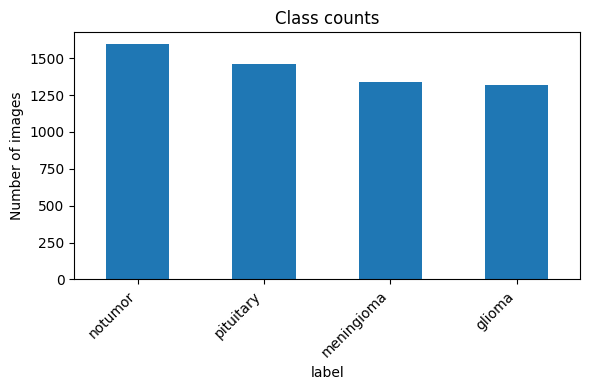

In [9]:
class_counts = df["label"].value_counts().sort_values(ascending=False)
display(class_counts)

plt.figure(figsize=(6,4))
class_counts.plot(kind="bar")
plt.title("Class counts")
plt.ylabel("Number of images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 1.2 Train / Validation / Test split

We do:
- 70% train
- 15% validation
- 15% test

All splits are stratified by label.


In [10]:
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train class distribution:\n", train_df["label"].value_counts(normalize=True))


Train: 3998 Val: 857 Test: 857
Train class distribution:
 label
notumor       0.279140
pituitary     0.255128
meningioma    0.234367
glioma        0.231366
Name: proportion, dtype: float64


### 1.3 Visual inspection

We display a few random examples from each class to sanity-check labels and image quality.


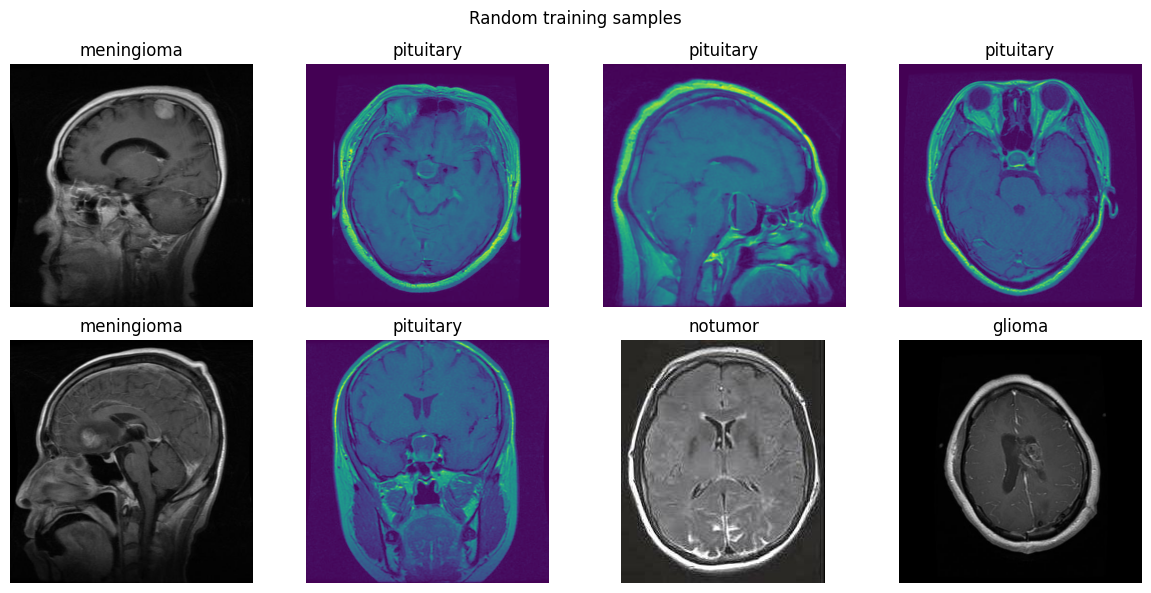

In [11]:
import matplotlib.image as mpimg

def show_random_images(df_in, n=8, title="Samples"):
    sample_df = df_in.sample(n=min(n, len(df_in)), random_state=SEED)
    plt.figure(figsize=(12, 6))
    for i, (_, row) in enumerate(sample_df.iterrows(), start=1):
        img = mpimg.imread(row["filepath"])
        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(row["label"])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(train_df, n=8, title="Random training samples")


## 2. Input pipeline (tf.data) + Data augmentation

Because datasets can be small, we use **data augmentation** to reduce overfitting.  
Augmentation applies random transformations that preserve the label (e.g., small rotations).

We implement a TensorFlow `tf.data` pipeline for speed and clarity.


In [12]:
IMG_SIZE = (224, 224)  # standard for many pretrained models
BATCH_SIZE = 32

label_names = sorted(df["label"].unique().tolist())
num_classes = len(label_names)
label_to_index = {name: i for i, name in enumerate(label_names)}

print("Label names:", label_names)
print("Num classes:", num_classes)


Label names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Num classes: 4


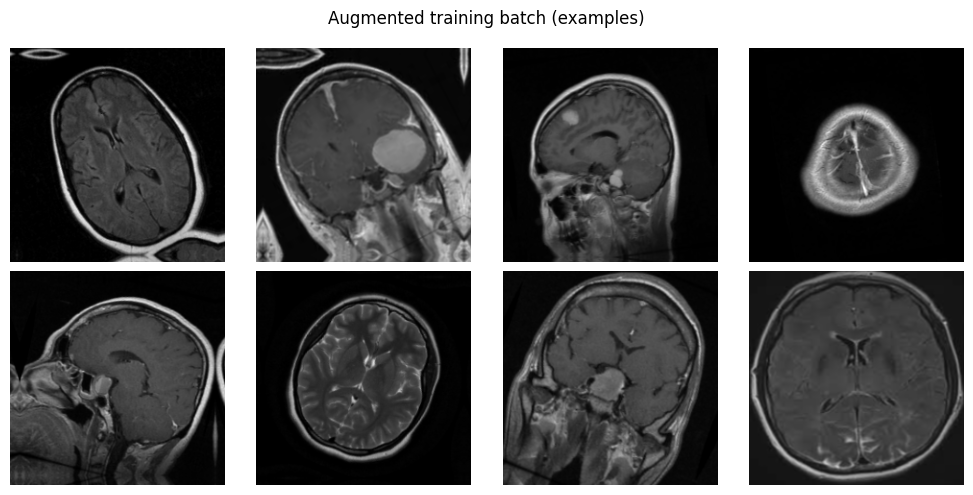

In [13]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df_in, shuffle=False, augment=False):
    paths = df_in["filepath"].values
    labels = df_in["label"].map(label_to_index).values
    labels = tf.one_hot(labels, depth=num_classes)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_in), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: decode_and_resize(p, y), num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="data_augmentation")

train_ds = make_dataset(train_df, shuffle=True, augment=True)
val_ds   = make_dataset(val_df, shuffle=False, augment=False)
test_ds  = make_dataset(test_df, shuffle=False, augment=False)

# Preview augmented images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,5))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.suptitle("Augmented training batch (examples)")
    plt.tight_layout()
    plt.show()


## 3. Baseline (Classical ML): HOG + Logistic Regression

**Goal:** show why deep learning is beneficial.

We extract **HOG** (Histogram of Oriented Gradients) features from each image and train a **Logistic Regression** classifier.

This baseline:
- is fast and simple,
- but cannot learn complex hierarchical representations like a CNN.

> This is great content for the methodology section: it motivates CNNs instead of “using deep learning because it works”.


In [14]:
# Helper: load images into numpy for baseline
import cv2

BASELINE_SIZE = (128, 128)  # smaller for faster HOG

def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, BASELINE_SIZE)
    return img

def hog_features(img):
    # HOG expects grayscale
    gray = rgb2gray(img)
    feat = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    return feat

def make_hog_dataset(df_in, max_items=None):
    df_use = df_in.copy()
    if max_items is not None:
        df_use = df_use.sample(n=min(max_items, len(df_use)), random_state=SEED)

    X, y = [], []
    for _, row in df_use.iterrows():
        img = load_image_cv2(row["filepath"])
        X.append(hog_features(img))
        y.append(row["label"])
    return np.array(X), np.array(y)

# HOG can be slow if the dataset is large; you can cap max_items if needed
X_train_hog, y_train_hog = make_hog_dataset(train_df)
X_val_hog, y_val_hog = make_hog_dataset(val_df)
X_test_hog, y_test_hog = make_hog_dataset(test_df)

print("HOG shapes:", X_train_hog.shape, X_val_hog.shape, X_test_hog.shape)


HOG shapes: (3998, 8100) (857, 8100) (857, 8100)


In [15]:
baseline_clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto")
baseline_clf.fit(X_train_hog, y_train_hog)

val_pred = baseline_clf.predict(X_val_hog)
test_pred = baseline_clf.predict(X_test_hog)

print("Baseline (HOG+LogReg) validation accuracy:", accuracy_score(y_val_hog, val_pred))
print("Baseline (HOG+LogReg) test accuracy:", accuracy_score(y_test_hog, test_pred))

print("\nClassification report (test):")
print(classification_report(y_test_hog, test_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline (HOG+LogReg) validation accuracy: 0.9171528588098017
Baseline (HOG+LogReg) test accuracy: 0.9101516919486581

Classification report (test):
              precision    recall  f1-score   support

      glioma       0.94      0.84      0.89       198
  meningioma       0.81      0.87      0.84       201
     notumor       0.95      0.96      0.96       240
   pituitary       0.93      0.95      0.94       218

    accuracy                           0.91       857
   macro avg       0.91      0.91      0.91       857
weighted avg       0.91      0.91      0.91       857



## 4. Deep Learning Model 1: CNN trained from scratch

We start with a compact CNN:

- Convolution blocks extract features
- Batch Normalization stabilizes training
- Dropout reduces overfitting
- GlobalAveragePooling reduces parameters compared to Flatten()

We train using categorical cross-entropy and Adam optimizer.


In [16]:
def build_cnn_from_scratch(input_shape=(224,224,3), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="cnn_from_scratch")
    return model

cnn_model = build_cnn_from_scratch(num_classes=num_classes)
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()


Model: "cnn_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,364 (1.49 MB)

 Trainable params: 390,404 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

### 4.1 Training protocol

We monitor validation performance and use:
- **EarlyStopping**: stops when validation loss stops improving (prevents overfitting)
- **ReduceLROnPlateau**: reduces learning rate if learning stagnates


In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6),
]

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.6375 - loss: 0.8857 - val_accuracy: 0.2602 - val_loss: 3.3262 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - accuracy: 0.7308 - loss: 0.6785 - val_accuracy: 0.2824 - val_loss: 3.6510 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 808s 6s/step - accuracy: 0.7703 - loss: 0.6029 - val_accuracy: 0.2730 - val_loss: 2.0460 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.7600 - loss: 0.6156 - val_accuracy: 0.5064 - val_loss: 1.0425 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - accuracy: 0.7905 - loss: 0.5582 - val_accuracy: 0.7550 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 793s 6s/step - accuracy: 0.7993 - loss: 0.5316 - val_accuracy: 0.8040 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 791s 6s/step - accuracy: 0.8018 - loss: 0.

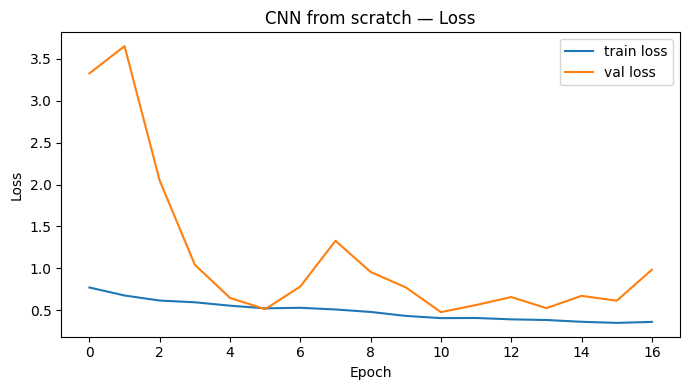

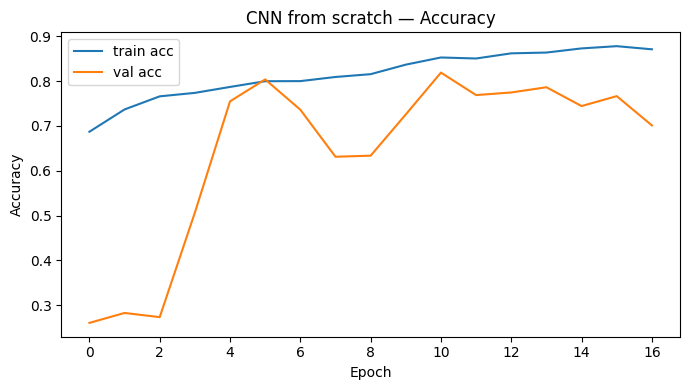

In [18]:
def plot_history(history, title="Training history"):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(7,4))
    plt.plot(hist["loss"], label="train loss")
    plt.plot(hist["val_loss"], label="val loss")
    plt.title(title + " — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(hist["accuracy"], label="train acc")
    plt.plot(hist["val_accuracy"], label="val acc")
    plt.title(title + " — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_cnn, title="CNN from scratch")


### 4.2 Evaluation on test set

We compute:
- Accuracy
- Confusion matrix
- Precision / Recall / F1 for each class

This is critical: it shows performance per class, not only overall accuracy.


CNN from scratch — Test accuracy: 0.8028004765510559

Classification report (test):
              precision    recall  f1-score   support

      glioma       0.96      0.71      0.81       198
  meningioma       0.73      0.55      0.62       201
     notumor       0.96      0.92      0.94       240
   pituitary       0.66      1.00      0.79       218

    accuracy                           0.80       857
   macro avg       0.83      0.79      0.79       857
weighted avg       0.83      0.80      0.80       857



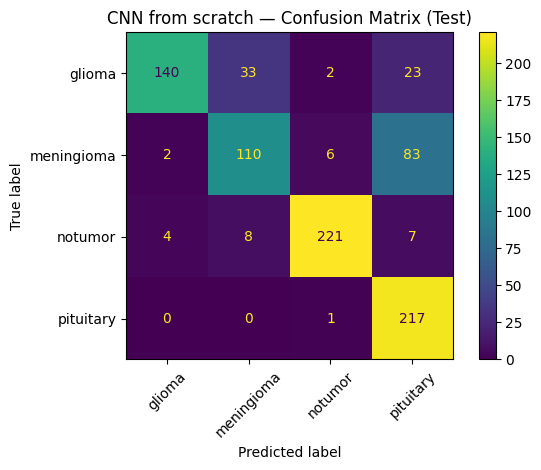

In [19]:
test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=0)
print("CNN from scratch — Test accuracy:", test_acc)

# Get predictions
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)
y_prob = np.concatenate([cnn_model.predict(x, verbose=0) for x, _ in test_ds], axis=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=label_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.title("CNN from scratch — Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


## 5. Deep Learning Model 2: Transfer Learning (EfficientNet)

When the dataset is limited, training a CNN from scratch may overfit. **Transfer learning** addresses this by starting from a model pretrained on a large dataset (e.g., ImageNet).

Method:
1. Load pretrained backbone (EfficientNetB0)
2. Freeze it (initially) and train a small classification head
3. Optionally fine-tune a few top layers

We expect:
- faster convergence,
- improved generalization,
- better performance stability.


In [20]:
def build_efficientnet_transfer(input_shape=(224,224,3), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    # EfficientNet expects inputs scaled in a specific way
    x = layers.Rescaling(255.0)(inputs)  # back to [0,255] for preprocess_input
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling=None
    )
    base.trainable = False  # freeze for first stage

    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="efficientnet_transfer")
    return model

tl_model = build_efficientnet_transfer(num_classes=num_classes)
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnet_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history_tl_stage1 = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

plot_history(history_tl_stage1, title="EfficientNet (frozen backbone)")


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.6160 - loss: 0.9490 - val_accuracy: 0.7025 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8238 - loss: 0.5044 - val_accuracy: 0.7561 - val_loss: 0.5888 - learning_rate: 0.0010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.8506 - loss: 0.4149 - val_accuracy: 0.7900 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.8478 - loss: 0.4082 - val_accuracy: 0.8238 - val_loss: 0.4447 - learning_rate: 0.0010
Epoch 5/15
  9/125 ━━━━━━━━━━━━━━━━━━━━ 4:21 2s/step - accuracy: 0.8826 - loss: 0.3131

### 5.1 Optional fine-tuning (recommended)

After the head is trained, we can unfreeze the last layers of the backbone and fine-tune with a smaller learning rate.

This can improve accuracy, but may also increase overfitting if not controlled properly.


In [ ]:
# Fine-tune last N layers
FINE_TUNE_LAYERS = 30

# Unfreeze
base_model = None
for layer in tl_model.layers:
    if isinstance(layer, keras.Model) and layer.name.startswith("efficientnet"):
        base_model = layer
        break

# If we cannot access base model by type above (sometimes wrapped), find by name
if base_model is None:
    for layer in tl_model.layers:
        if "efficientnet" in layer.name.lower():
            base_model = layer
            break

if base_model is None:
    # As fallback, try accessing by attribute in graph
    print("Warning: Could not directly locate EfficientNet submodel. Fine-tuning may be skipped.")
else:
    base_model.trainable = True

    # Freeze all except the last FINE_TUNE_LAYERS
    for l in base_model.layers[:-FINE_TUNE_LAYERS]:
        l.trainable = False

    tl_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_tl_stage2 = tl_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks,
        verbose=1
    )

    plot_history(history_tl_stage2, title="EfficientNet (fine-tuning)")


### 5.2 Evaluation (test set)


In [ ]:
test_loss_tl, test_acc_tl = tl_model.evaluate(test_ds, verbose=0)
print("EfficientNet transfer — Test accuracy:", test_acc_tl)

y_true_tl = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)
y_prob_tl = np.concatenate([tl_model.predict(x, verbose=0) for x, _ in test_ds], axis=0)
y_pred_tl = np.argmax(y_prob_tl, axis=1)

print("\nClassification report (test):")
print(classification_report(y_true_tl, y_pred_tl, target_names=label_names))

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tl, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.title("EfficientNet transfer — Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


## 6. ROC-AUC / PR-AUC (binary case)

ROC-AUC is strictly well-defined for **binary** classification.  
If your dataset has more than 2 classes, we can compute **one-vs-rest** AUC per class.

Below we compute:
- ROC curves per class (one-vs-rest)
- Macro-average AUC

This helps evaluate ranking quality and is useful when class imbalance exists.


In [ ]:
# One-vs-rest AUC for multi-class
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true_tl, classes=list(range(num_classes)))

auc_per_class = []
plt.figure(figsize=(7,5))
for c in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_prob_tl[:, c])
    auc_c = roc_auc_score(y_true_bin[:, c], y_prob_tl[:, c])
    auc_per_class.append(auc_c)
    plt.plot(fpr, tpr, label=f"{label_names[c]} AUC={auc_c:.3f}")

plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC curves (one-vs-rest) — EfficientNet")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

print("AUC per class:", dict(zip(label_names, auc_per_class)))
print("Macro-average AUC:", float(np.mean(auc_per_class)))


## 7. Error analysis (qualitative)

We visualize a few **misclassified** examples. This is extremely valuable in a report because it:
- demonstrates critical thinking,
- highlights dataset ambiguity/noise,
- gives insight into failure modes.

We show image + true label + predicted label + predicted confidence.


In [ ]:
import matplotlib.image as mpimg

# Build a list of test filepaths in same order as y_true (we need to re-iterate test_ds)
test_paths = []
test_labels = []
for batch_paths, batch_labels in tf.data.Dataset.from_tensor_slices((test_df["filepath"].values,
                                                                    test_df["label"].map(label_to_index).values)).batch(BATCH_SIZE):
    test_paths.extend(batch_paths.numpy().astype(str).tolist())
    test_labels.extend(batch_labels.numpy().tolist())

# Because test_df ordering matches the dataset above, we can use y_pred_tl alignment.
# But to be safe, we will align on test_df order directly:
assert len(test_paths) == len(test_df)

pred_idx = y_pred_tl[:len(test_df)]
true_idx = test_df["label"].map(label_to_index).values

mis = np.where(pred_idx != true_idx)[0]
print("Misclassified:", len(mis), "out of", len(test_df))

def show_misclassified(k=8):
    if len(mis) == 0:
        print("No misclassifications to display.")
        return
    chosen = np.random.choice(mis, size=min(k, len(mis)), replace=False)
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(chosen, start=1):
        path = test_df.iloc[idx]["filepath"]
        img = mpimg.imread(path)
        true_label = test_df.iloc[idx]["label"]
        pred_label = label_names[pred_idx[idx]]
        conf = float(np.max(y_prob_tl[idx]))

        plt.subplot(2, 4, i)
        plt.imshow(img)
        plt.title(f"T: {true_label}\nP: {pred_label} ({conf:.2f})")
        plt.axis("off")
    plt.suptitle("Misclassified examples — EfficientNet")
    plt.tight_layout()
    plt.show()

show_misclassified(k=8)


## 8. Summary table of results

We compare:
- HOG + Logistic Regression baseline
- CNN from scratch
- EfficientNet transfer learning

In the report, you can discuss:
- Why transfer learning may outperform training-from-scratch on limited data
- Which classes are confusing and why
- Whether improvements are statistically meaningful (optional)


In [ ]:
results = pd.DataFrame([
    {"Model": "HOG + Logistic Regression", "Test Accuracy": accuracy_score(y_test_hog, test_pred)},
    {"Model": "CNN from scratch", "Test Accuracy": test_acc},
    {"Model": "EfficientNet transfer", "Test Accuracy": test_acc_tl},
]).sort_values("Test Accuracy", ascending=False)

results


## 9. (Report-ready) Methodology checklist

To align with your professor's criteria, make sure your report includes:

### Aspect 1 — Methodology/Theory (most important)
- Formal problem definition
- Why CNNs are suitable for images (locality, weight sharing)
- Data split rationale (avoid leakage)
- Augmentation rationale (generalization)
- Baseline motivation
- Transfer learning intuition (feature reuse)

### Aspect 2 — Interpretation
- Confusion matrices
- Recall/sensitivity discussion (false negatives in medical context)
- Error analysis examples
- Limitations (dataset size, bias, MRI variability)

### Aspect 3 — Implementation
- Key hyperparameters (image size, batch size, optimizer, LR schedule)
- Training stabilization (BN, dropout, callbacks)

---

## 10. Optional extensions (if you want to go further)
- Probability calibration (temperature scaling / reliability diagrams)
- Model interpretability (Grad-CAM)
- K-fold cross validation (more robust evaluation)
